In [224]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import numpy as np
import re

## Example

In [122]:
df = pd.read_csv('test4.txt', sep=',', header=None)
df.columns = ['sensor1', 'sensor2']
df

,sensor1,sensor2
0,5,5
1,5,5
2,5,5
3,5,5
4,5,5
...,...,...
99995,5,5
99996,5,5
99997,5,5
99998,5,5


In [123]:
print(df['sensor1'].unique()) # 0 is DROP DETECTED 
print(df['sensor2'].unique()) 

df = df.applymap(lambda x: 1 if x != 0 else 0)
print(df['sensor1'].unique()) # 0 is DROP DETECTED 
print(df['sensor2'].unique()) # 5,4,3,2,1 mapped to 1
df = df.applymap(lambda x: 1 if x == 0 else 0)

print(df['sensor1'].unique()) # 1 is DROP DETECTED 
print(df['sensor2'].unique()) 
df

[5 0 4 3 2]
[5 0 4 3 1]
[1 0]
[1 0]
[0 1]
[0 1]


,sensor1,sensor2
0,0,0
1,0,0
2,0,0
3,0,0
4,0,0
...,...,...
99995,0,0
99996,0,0
99997,0,0
99998,0,0


In [124]:
# need time between drops
df['OR'] = df['sensor1'] | df['sensor2'] # drop detected
df[df['sensor1']==0] # times wehre no drops were detected


,sensor1,sensor2,OR
0,0,0,0
1,0,0,0
2,0,0,0
3,0,0,0
4,0,0,0
...,...,...,...
99995,0,0,0
99996,0,0,0
99997,0,0,0
99998,0,0,0


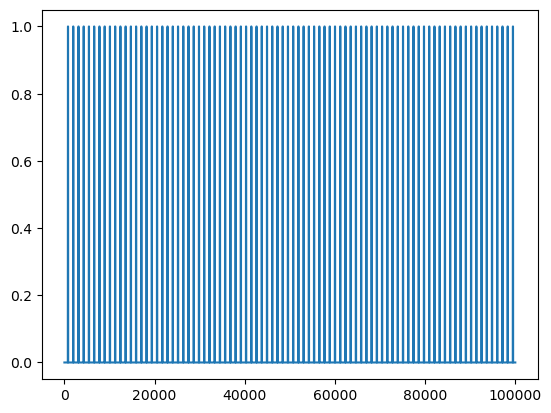

In [131]:
plt.plot(df['OR'])
plt.show()

[1110, 1111, 1107, 1106, 1111, 1113, 1110, 1111, 1110, 1106, 1110, 1108, 1107, 1108, 1111, 1110, 1112, 1111, 1109, 1109, 1110, 1111, 1108, 1108, 1110, 1107, 1109, 1109, 1109, 1107, 1111, 1106, 1107, 1106, 1111, 1109, 1107, 1110, 1107, 1109, 1109, 1109, 1108, 1105, 1108, 1107, 1109, 1108, 1104, 1105, 1108, 1110, 1105, 1108, 1108, 1109, 1106, 1108, 1109, 1108, 1110, 1108, 1111, 1107, 1111, 1107, 1110, 1111, 1108, 1110, 1109, 1111, 1108, 1109, 1106, 1109, 1110, 1111, 1107, 1105, 1105, 1110, 1109, 1108, 1108]
85
85


Text(0, 0.5, 'periods[i+1]')

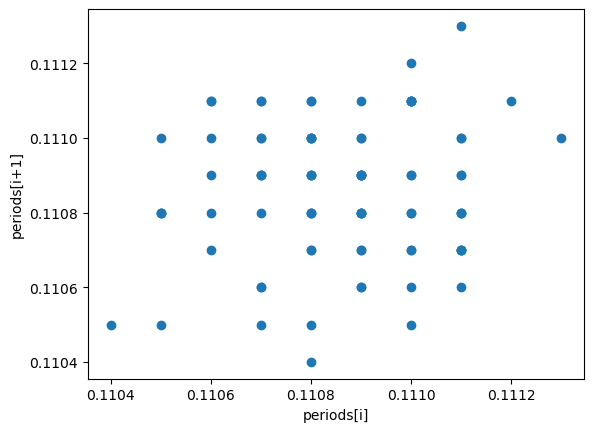

In [127]:
l = df['OR'].tolist() # list of 0s and 1s
# l = [0,0,0,0,0,0,1,1,1,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,1,1,0,1]

periods = []
count_between_drop = 0

first_drop = l.index(1) # start at first occurrence of a drop
for i in range(first_drop, len(l)):
    if l[i] == 1 and count_between_drop != 0: # no drop detected AND count between drop != 0
        periods.append(count_between_drop)
        count_between_drop = 0
    if l[i] == 0: # no drop detected
        count_between_drop += 1 
            
print(periods)
f = 10000
print(len(periods))
periods = np.array(periods)*1/f # seconds
print(len(periods))

plt.scatter(periods[0:-1], periods[1:])
plt.xlabel('periods[i]')
plt.ylabel('periods[i+1]')
# plt.xlim(0,0.6)
# plt.ylim(0,0.6)

## Analysis

In [236]:
from matplotlib.ticker import StrMethodFormatter

def analysis(file, fr, freq=10000, mute_period=False, plot=True, return_vals=False, xlim=None, xzoom=None, ylim=None, yzoom=None):
    """
    Given a file of sensor data and flow rate fr, 
    Output periods and fr in tuple.
    By default, create Poincare section plots
    """
    df = pd.read_csv(file, sep=',', header=None)
    df.columns = ['sensor1', 'sensor2']
    print(f'[{file}]: Initial unique values of sensors')
    print(f'    Sensor 1: {df["sensor1"].unique()}') # 0 is DROP DETECTED 
    print(f'    Sensor 2: {df["sensor2"].unique()}')
    print(f'Transformation: nonzero -> 1')
    df = df.applymap(lambda x: 1 if x != 0 else 0)
    print(f'    Sensor 1: {df["sensor1"].unique()}') # 0 is DROP DETECTED 
    print(f'    Sensor 2: {df["sensor2"].unique()}') # 5,4,3,2,1 mapped to 1
    print(f'Transformation: Switch 0s and 1s')
    df = df.applymap(lambda x: 1 if x == 0 else 0)
    print(f'    Sensor 1: {df["sensor1"].unique()}') # 1 is DROP DETECTED 
    print(f'    Sensor 2: {df["sensor2"].unique()}')
    print('----------------------------------------------')

    # OR Gate
    df['OR'] = df['sensor1'] | df['sensor2'] # detecting drops in either sensor

    if not mute_period:
        plt.figure()
        plt.title("Visualization of Periods")
        plt.plot(df['OR'])
        plt.xlabel('Time step')
        plt.ylabel('1 or 0')

    l = df['OR'].tolist() # list of 0s and 1s

    # counting time between drops
    periods = []
    count_between_drop = 0

    first_drop = l.index(1) # start at first occurrence of a drop
    for i in range(first_drop, len(l)):
        if l[i] == 1 and count_between_drop != 0: # no drop detected AND count between drop != 0
            periods.append(count_between_drop)
            count_between_drop = 0
        if l[i] == 0: # no drop detected
            count_between_drop += 1 

    periods = np.array(periods)*1/freq # convert to seconds

    if plot:
        fig, ax = plt.subplots()
        ax.set_title(f'Poincare Section Plots (Flow Rate: {fr:.2f}g/min)')
        ax.scatter(periods[0:-1], periods[1:])
        ax.set_xlabel('$T_{n} (s)$')
        ax.set_ylabel('$T_{n+1} (s)$')
        ax.xaxis.set_major_formatter(StrMethodFormatter(f'{{x:.3f}}'))
        ax.yaxis.set_major_formatter(StrMethodFormatter(f'{{x:.3f}}'))

        ax.set_xlim(xlim,xzoom)
        ax.set_ylim(ylim,yzoom)
    
    if return_vals:
        return periods, periods[0:-1], periods[1:], fr

## Sample Runs

test5.txt: Initial unique values of sensors
Sensor 1: [5 0 4 2 3 1]
Sensor 2: [5 0 4 2 3 1]
Transformation: nonzero -> 1
Sensor 1: [1 0]
Sensor 2: [1 0]
Transformation: Switch 0s and 1s
Sensor 1: [0 1]
Sensor 2: [0 1]
----------------------------------------------


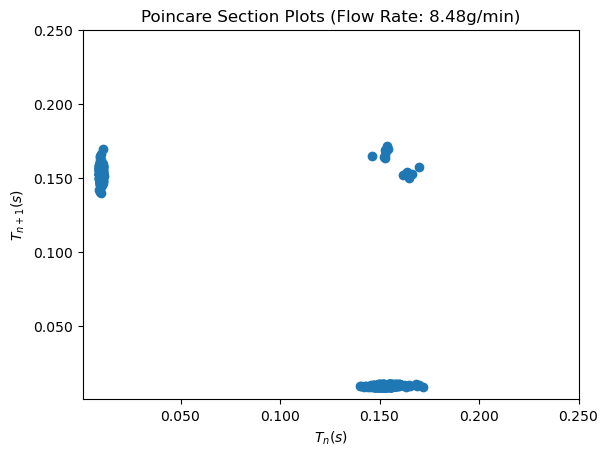

In [204]:
analysis('test5.txt', fr=0.1413*60, mute_period=True, xzoom=0.25, yzoom=0.25)

## Trials

t1.txt: Initial unique values of sensors
Sensor 1: [5 0 3 4 2]
Sensor 2: [5 0 4 1 2]
Transformation: nonzero -> 1
Sensor 1: [1 0]
Sensor 2: [1 0]
Transformation: Switch 0s and 1s
Sensor 1: [0 1]
Sensor 2: [0 1]
----------------------------------------------


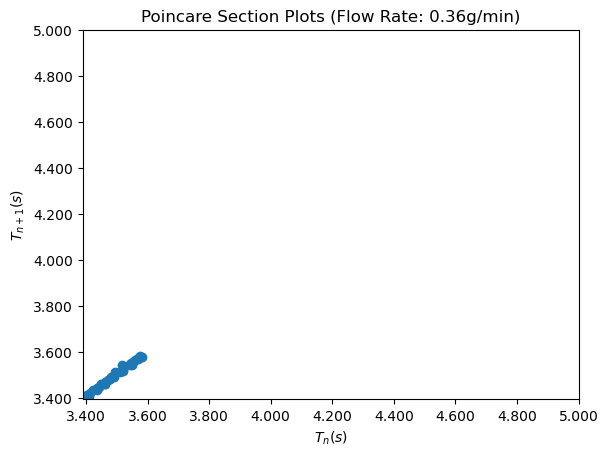

In [205]:
analysis('t1.txt', fr=0.006008*60, mute_period=True, xzoom=5, yzoom=5)

t2.txt: Initial unique values of sensors
Sensor 1: [5 0 4 3 1]
Sensor 2: [5 0 4 3 1 2]
Transformation: nonzero -> 1
Sensor 1: [1 0]
Sensor 2: [1 0]
Transformation: Switch 0s and 1s
Sensor 1: [0 1]
Sensor 2: [0 1]
----------------------------------------------
t3.txt: Initial unique values of sensors
Sensor 1: [5 0 4 3]
Sensor 2: [5 0 4 3 2 1]
Transformation: nonzero -> 1
Sensor 1: [1 0]
Sensor 2: [1 0]
Transformation: Switch 0s and 1s
Sensor 1: [0 1]
Sensor 2: [0 1]
----------------------------------------------


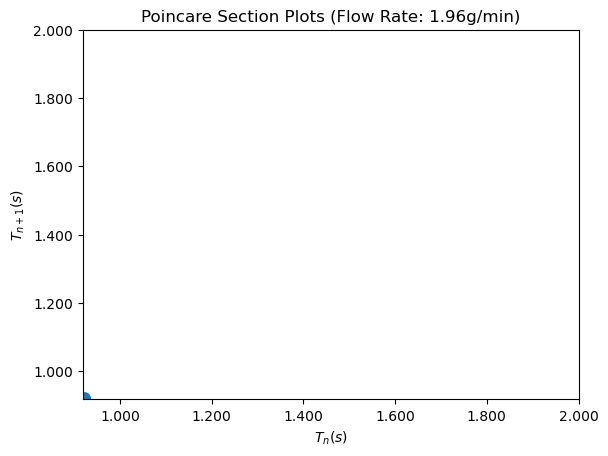

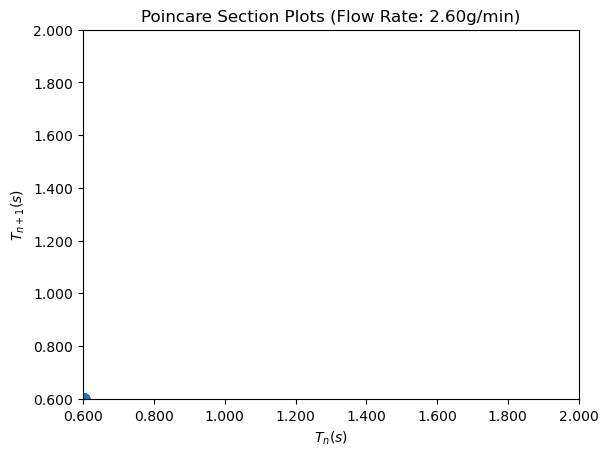

In [206]:
analysis('t2.txt', fr=0.03264*60, mute_period=True, xzoom=2,yzoom=2)#, xzoom=0.25, yzoom=0.25) # UNKNOWN FLOW RATE
analysis('t3.txt', fr=0.04332*60, mute_period=True, xzoom=2,yzoom=2)#, xzoom=0.25, yzoom=0.25)

t4.txt: Initial unique values of sensors
Sensor 1: [5 0 4 3 1]
Sensor 2: [5 0 4 3 2 1]
Transformation: nonzero -> 1
Sensor 1: [1 0]
Sensor 2: [1 0]
Transformation: Switch 0s and 1s
Sensor 1: [0 1]
Sensor 2: [0 1]
----------------------------------------------
t5.txt: Initial unique values of sensors
Sensor 1: [5 0 4 1 3 2]
Sensor 2: [5 0 4 3]
Transformation: nonzero -> 1
Sensor 1: [1 0]
Sensor 2: [1 0]
Transformation: Switch 0s and 1s
Sensor 1: [0 1]
Sensor 2: [0 1]
----------------------------------------------


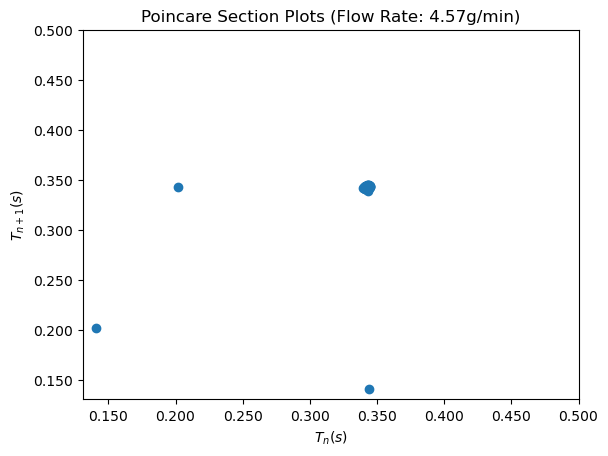

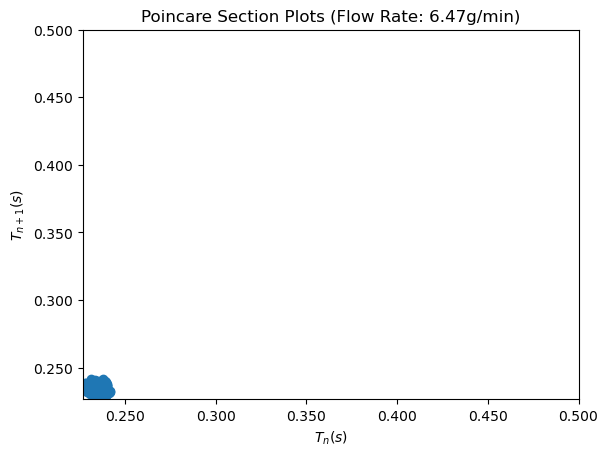

In [207]:
analysis('t4.txt', fr=0.0761*60, mute_period=True, xzoom=0.5, yzoom=0.5)
analysis('t5.txt', fr=0.1078*60, mute_period=True, xzoom=0.50, yzoom=0.5)


Initial unique values of sensors
Sensor 1: [5 0 4 2 3 1]
Sensor 2: [5 0 4 1 3]
Transformation: nonzero -> 1
Sensor 1: [1 0]
Sensor 2: [1 0]
Transformation: Switch 0s and 1s
Sensor 1: [0 1]
Sensor 2: [0 1]
Initial unique values of sensors
Sensor 1: [5 0 4 3 2 1]
Sensor 2: [5 0 4 3 1 2]
Transformation: nonzero -> 1
Sensor 1: [1 0]
Sensor 2: [1 0]
Transformation: Switch 0s and 1s
Sensor 1: [0 1]
Sensor 2: [0 1]


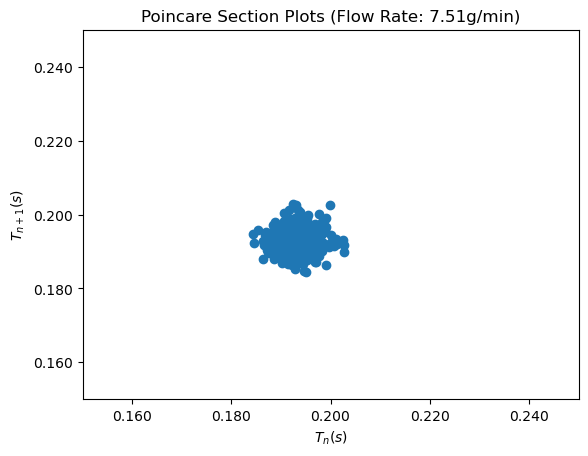

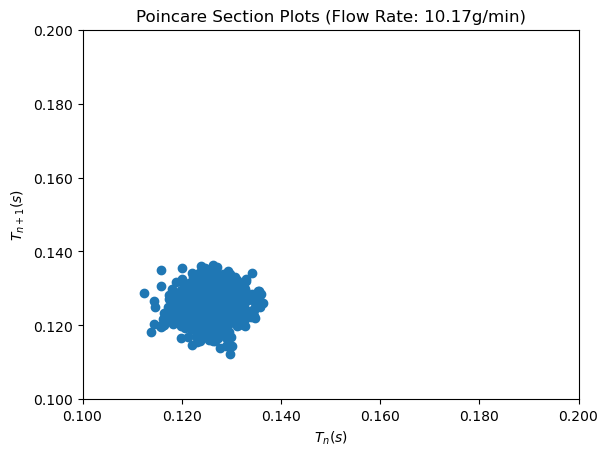

In [199]:
analysis('t6.txt', fr=0.1251*60, mute_period=True, xlim=0.15, ylim=0.15, xzoom=0.25, yzoom=0.25)
analysis('t7.txt', fr=0.1695*60, mute_period=True, xlim=0.1, ylim=0.1, xzoom=0.2, yzoom=0.2)


[d7.txt]: Initial unique values of sensors
    Sensor 1: [5 0 3 4 2 1]
    Sensor 2: [5 0 4 2 3 1]
Transformation: nonzero -> 1
    Sensor 1: [1 0]
    Sensor 2: [1 0]
Transformation: Switch 0s and 1s
    Sensor 1: [0 1]
    Sensor 2: [0 1]
----------------------------------------------
[d8.txt]: Initial unique values of sensors
    Sensor 1: [5 0 4 3 2 1]
    Sensor 2: [5 0 4 1 3]
Transformation: nonzero -> 1
    Sensor 1: [1 0]
    Sensor 2: [1 0]
Transformation: Switch 0s and 1s
    Sensor 1: [0 1]
    Sensor 2: [0 1]
----------------------------------------------
[d9.txt]: Initial unique values of sensors
    Sensor 1: [5 0 4 3 1 2]
    Sensor 2: [5 0 4 3 1 2]
Transformation: nonzero -> 1
    Sensor 1: [1 0]
    Sensor 2: [1 0]
Transformation: Switch 0s and 1s
    Sensor 1: [0 1]
    Sensor 2: [0 1]
----------------------------------------------
[d10.txt]: Initial unique values of sensors
    Sensor 1: [5 0 4 1 3 2]
    Sensor 2: [5 0 4 1 3 2]
Transformation: nonzero -> 1
    Senso

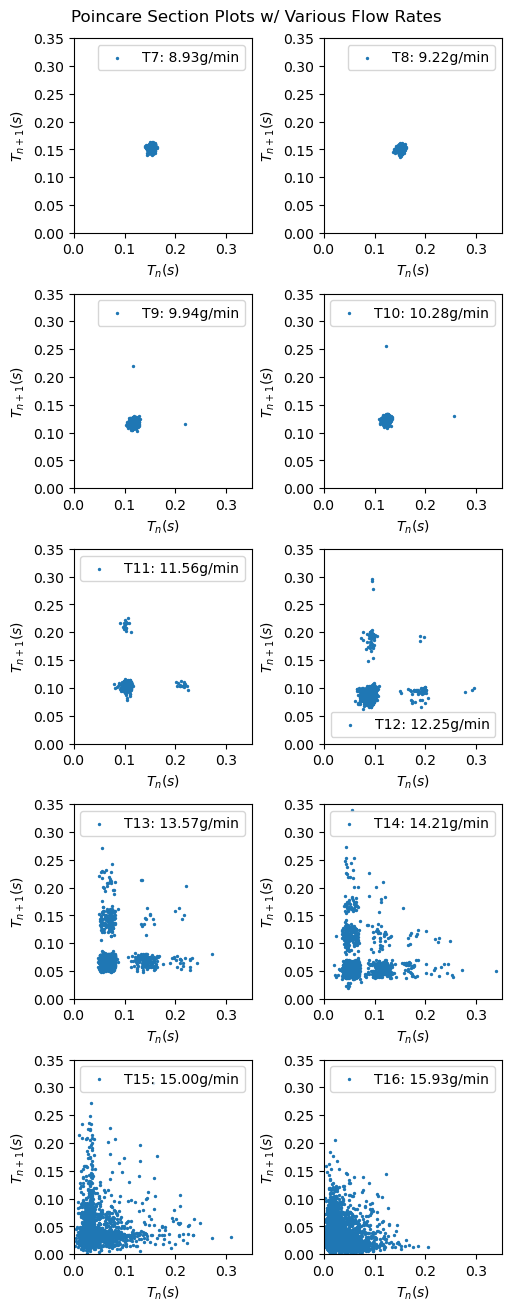

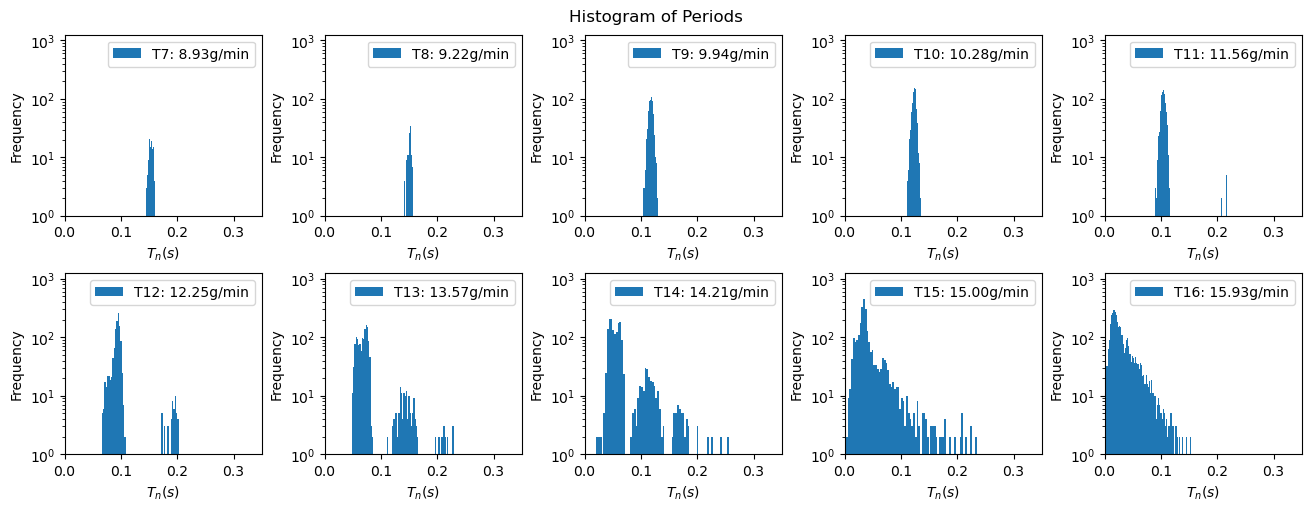

In [246]:
data = [
    ('d7.txt', 0.1488),
    ('d8.txt', 0.1536),
    ('d9.txt', 0.1657),
    ('d10.txt', 0.1714),
    ('d11.txt', 0.1927),
    ('d12.txt', 0.2042),
    ('d13.txt', 0.2262),
    ('d14.txt', 0.2369),
    ('d15.txt', 0.2500),
    ('d16.txt', 0.2655)

    # ('d17.txt', 0.2810),
    # ('d18.txt', 0.2991),
    # ('d19.txt', 0.3071),
    # ('d20.txt', 0.3214),
    # ('d21.txt', 0.3321),
    # ('d22.txt', 0.3457)
    # ('d23.txt', 0.3571)
    ]

assert(len(data)%2 == 0)
fig = plt.figure(figsize=(5,13), layout='constrained')
fig1 = plt.figure(figsize=(13,5), layout='constrained')
gs = gridspec.GridSpec(len(data)//2, 2, figure=fig)
gs1 = gridspec.GridSpec(2, len(data)//2, figure=fig1)

for idx, (file, fr_sec) in enumerate(data):
    pt, pt0, pt1, flow_rate = analysis(file, fr=fr_sec*60, mute_period=True, return_vals=True, plot=False)
    trial_num = re.findall(r'\d+', file)[-1]

    ax = fig.add_subplot(gs[idx])
    ax.set_xlim([0.0, 0.35])
    ax.set_ylim([0.0, 0.35])
    ax.set_xlabel('$T_{n} (s)$')
    ax.set_ylabel('$T_{n+1} (s)$')
    ax.scatter(pt0, pt1, label=f'T{trial_num}: {flow_rate:.2f}g/min', s=2)
    ax.legend()

    ax1 = fig1.add_subplot(gs1[idx])
    ax1.set_xlim([0.0, 0.35])
    ax1.set_ylim([10**0, 10**3.1])
    ax1.set_xlabel('$T_{n} (s)$')
    ax1.set_ylabel('Frequency')
    
    ax1.hist(pt, log=True, bins=100, label=f'T{trial_num}: {flow_rate:.2f}g/min')
    ax1.legend()

fig.suptitle('Poincare Section Plots w/ Various Flow Rates')
fig1.suptitle('Histogram of Periods')

fig.savefig('figs/poincare.png')
fig1.savefig('figs/period_hist.png')
